In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seastar as ss
from scipy.optimize import curve_fit
import cartopy.crs as ccrs
import cartopy.feature as cfeature
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
# Data load and pre-processing
#version = 'v20221104'
version = 'v20230411'
#flight = '20220522'
#oscar_path = "../DATA/OSCAR/" + version + "/matlab-pre-processed/"
flights = ['20220517', '20220522', '20220526']

# all_tracks=[{'0517_1' : 3, '0517_2' : 4, '0517_1b' : 5, '0517_L1': 6},
#             {'0522_L1' : 0, '0522_1a' : 1, '0522_2a' : 2, '0522_1b' : 3, '0522_2b' : 11, '0522_L2' : 12},
#             {'0526_2' : 0, '0526_1' : 1, '0526_L1' : 12}
#            ]
all_tracks=[{'0517_L1': 6},
            {'0522_L1' : 0, '0522_L2' : 12},
            {'0526_L1' : 12}
           ]
ds_L1b = dict()
vars_to_keep = ['LatImage', 'LonImage', 'IncidenceAngleImage', 'SquintImage', 'CentralFreq','OrbitHeadingImage',
                'SquintImage','CentralFreq']
for ii, flight in enumerate(flights):
    oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\" + version +'\\'+ flight + "\\matlab-pre-processed\\"
    file_time_triplets = ss.oscar.tools.find_file_triplets(oscar_path)
    print('OSCAR L1 processing - version ' + version + '\n-------------------')
    print('File path :', oscar_path + '\n-------------------')
    for i in range(len(file_time_triplets)):
        print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])

    for track in all_tracks[ii].keys():
        ds_ml = dict()
        file_index = all_tracks[ii][track]
        ds_L1a = ss.oscar.tools.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
        ds_L1a_dict_index = list(ds_L1a.keys())
        antenna_ident = ss.oscar.tools.identify_antenna_location_from_filename(
                            oscar_path,
                            file_time_triplets[file_index][1])
        print('Processing file index',file_index,'...')
        # L1b processing - loop through beams in L1a dataset dict
        #--------------------------------------------------------
        for dict_index in ds_L1a_dict_index:
            ds_L1a[dict_index] = ss.oscar.level1.replace_dummy_values(
                                     ds_L1a[dict_index],
                                     dummy_val=int(ds_L1a[dict_index].Dummy.data))
            ds_ml[dict_index] = ss.oscar.level1.compute_multilooking_Master_Slave(
                                    ds_L1a[dict_index],
                                    window=7)
#             ds_ml[dict_index]['Polarization'] = ss.oscar.level1.check_antenna_polarization(ds_L1a[dict_index])
#             ds_ml[dict_index]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
#             ds_ml[dict_index]['AntennaAzimuthImage'] =ss.oscar.level1.compute_antenna_azimuth_direction(
#                                                         ds_L1a[dict_index],
#                                                         antenna=antenna_ident[ds_L1a_dict_index.index(dict_index)])
#             ds_ml[dict_index]['TimeLag'] = ss.oscar.level1.compute_time_lag_Master_Slave(
#                                                ds_L1a[dict_index],
#                                                options='from_SAR_time')
            #ds_ml[dict_index][vars_to_keep] = ds_L1a[dict_index][vars_to_keep]
            ds_ml[dict_index] = ds_ml[dict_index].merge(ds_L1a[dict_index][vars_to_keep])
#             ds_ml[dict_index]['RadialSurfaceVelocity'] = ss.oscar.level1.compute_radial_surface_velocity(
#                                                              ds_ml[dict_index])
            
            ds_ml[dict_index].attrs['Title'] = ds_L1a[dict_index].Title
            ds_ml[dict_index]['TrackTime'] = ss.oscar.level1.track_title_to_datetime(ds_ml[dict_index].Title)
    #-----------------------------------------------------------
        ds_ml = ss.oscar.level1.fill_missing_variables(ds_ml, antenna_ident)
    # Build L1b dataset
        ds_L1b[track] = ss.oscar.level1.merge_beams(ds_ml, antenna_ident)
        del ds_ml, ds_L1a 
print('...Done')



OSCAR L1 processing - version v20230411
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\v20230411\20220517\matlab-pre-processed\
-------------------
File index : 0 , Aquisition time : 20220517T090013 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220517T090809 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220517T091519 , File list indices : [6, 7, 8]
File index : 3 , Aquisition time : 20220517T093239 , File list indices : [9, 10, 11]
File index : 4 , Aquisition time : 20220517T093818 , File list indices : [12, 13, 14]
File index : 5 , Aquisition time : 20220517T094339 , File list indices : [15, 16, 17]
File index : 6 , Aquisition time : 20220517T101737 , File list indices : [18, 19, 20]
Processing file index 6 ...
OSCAR L1 processing - version v20230411
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\v20230411\20220522\matlab-pre-processed\
-------------------
File index : 0 ,

# Find Interferogram over land

In [15]:
ds_phase = xr.Dataset(coords=ds_L1b[list(all_tracks[0].keys())[0]].drop_dims('Antenna')[["CrossRange","GroundRange"]])
ds_phase_list = []
count=0
for ii, flight in enumerate(flights):
    for track in all_tracks[ii].keys():
        print('Processing track ' + track +'...')
        if track not in ['0517_L1', '0522_L2', '0526_L1']:
            mask_fore = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1b[track].Interferogram.sel(Antenna='Fore'),
                                                                quiet=True, erosion=True)
            mask_aft = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1b[track].Interferogram.sel(Antenna='Aft'),
                                                                quiet=True, erosion=True)
        if track in ['0517_L1', '0522_L2', '0526_L1']:
            phase = [ds_L1b[track]\
                 .sel(Antenna='Fore')\
                 .Interferogram\
                 .mean(dim='CrossRange'),
                 ds_L1b[track]\
                 .sel(Antenna='Aft')\
                 .Interferogram\
                 .mean(dim='CrossRange')]
            incidence_angle = [ds_L1b[track]\
                               .sel(Antenna='Fore')\
                               .IncidenceAngleImage\
                               .median(dim='CrossRange'),
                               ds_L1b[track]\
                               .sel(Antenna='Aft')\
                               .IncidenceAngleImage\
                               .median(dim='CrossRange')]
        else:
            phase = [ds_L1b[track]\
                     .sel(Antenna='Fore')\
                     .Interferogram.where(mask_fore==1)\
                     .mean(dim='CrossRange'),
                     ds_L1b[track]\
                     .sel(Antenna='Aft')\
                     .Interferogram.where(mask_aft==1)\
                     .mean(dim='CrossRange')]
            incidence_angle = [ds_L1b[track]\
                               .sel(Antenna='Fore')\
                               .IncidenceAngleImage\
                               .where(mask_fore==1)\
                               .median(dim='CrossRange'),
                               ds_L1b[track]\
                               .sel(Antenna='Aft')\
                               .IncidenceAngleImage\
                               .where(mask_aft==1)\
                               .median(dim='CrossRange')]
        phase = xr.concat(phase, dim='Antenna')
        incidence_angle = xr.concat(incidence_angle, dim='Antenna')
        ds_phase_list.append(xr.merge([phase, incidence_angle]))
print('...done')
ds_phase = xr.concat(ds_phase_list, dim='Track')
track_names=[]
for ii, flight in enumerate(flights):
    for track in all_tracks[ii].keys():
        track_names.append(track)
ds_phase['Track'] = track_names

Processing track 0517_L1...
Processing track 0522_L1...
Processing track 0522_L2...
Processing track 0526_L1...
...done


<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


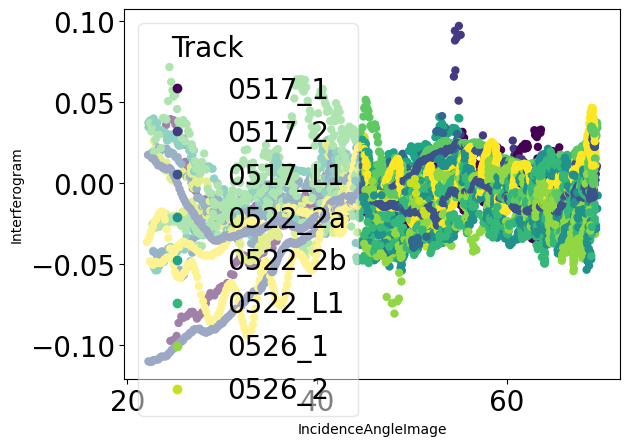

In [4]:
ds_phase.plot.scatter(x='IncidenceAngleImage', y='Interferogram', hue='Track', edgecolors='none',add_colorbar=False,)

# Fit linear function to Fore and Aft beams

In [6]:
IA

<xarray.Dataset>
Dimensions:     (parameters: 4, Antenna: 2)
Coordinates:
  * parameters  (parameters) object 'a' 'b' 'c' 'd'
  * Antenna     (Antenna) object 'Fore' 'Aft'
Data variables:
    bias        (Antenna, parameters) float64 ...
    func        object ...

In [12]:
phase_bias.bias

<xarray.DataArray 'bias' (Antenna: 2, parameters: 4)>
[8 values with dtype=float64]
Coordinates:
  * parameters  (parameters) object 'a' 'b' 'c' 'd'
  * Antenna     (Antenna) object 'Fore' 'Aft'

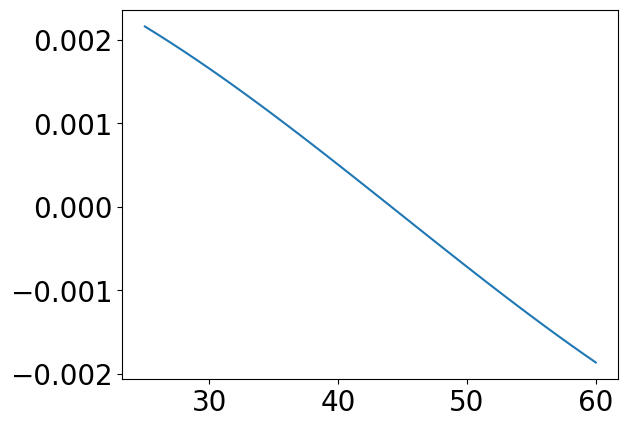

In [13]:
plt.plot(inci,fit_func_simple2(inci,*phase_bias.bias.sel(Antenna='Aft').data), label='Aft')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


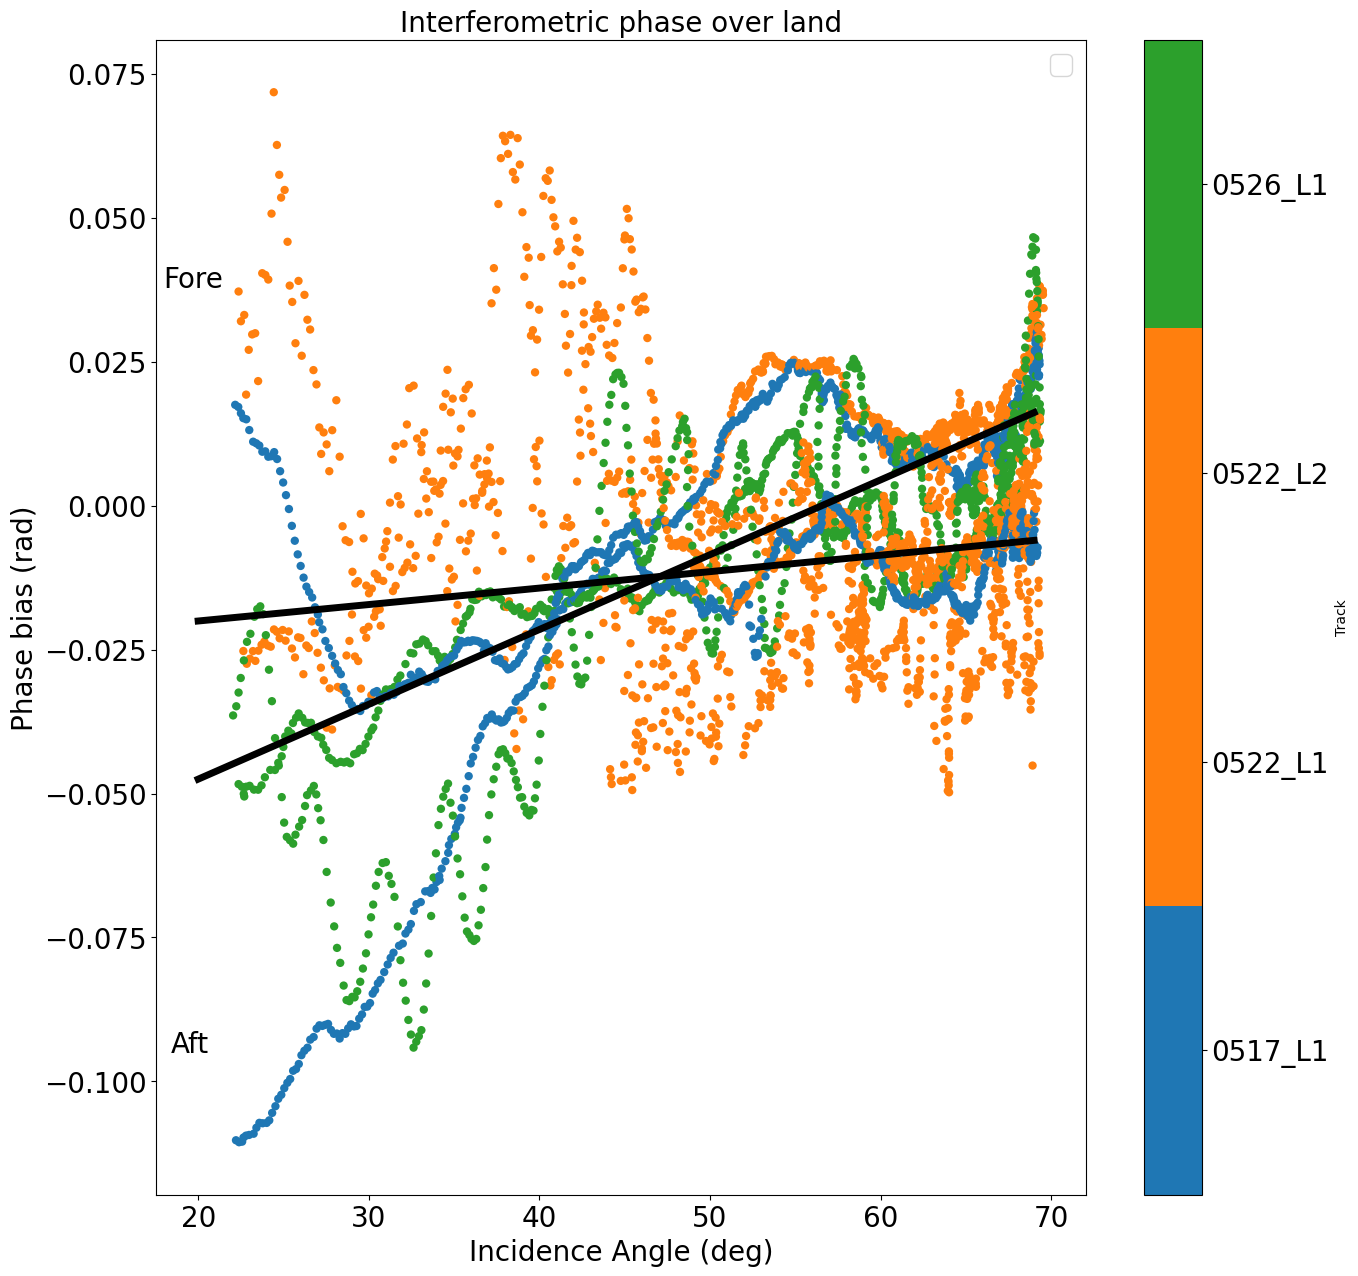

In [17]:
def func_linear(x, m, c):
     return m * x + c

# fit = ds_phase.sel(Antenna='Fore').Interferogram.curvefit(coords='GroundRange',
#                                                     func=func_linear,
#                                                     reduce_dims=['Track'],
#                                                     )
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
colors=['C0','C0','C0','C0','C1','C1','C1','C1','C1','C1', 'C2', 'C2','C2',]
#colors=['navy','blue','deepskyblue','peru','orange','navajowhite', 'darkgreen', 'seagreen']
#colors=['C0','C1','C2','C3','C4','C5','C6','C7']
#colors=['red','blue','yellow','green','pink','brown','cyan']
ds_phase.plot.scatter(x='IncidenceAngleImage', y='Interferogram', edgecolors='none',
                     hue='Track',
                     cmap=mpl.colors.ListedColormap(colors),
                     #cmap='Set1'
                     )
x = ds_phase.sel(Antenna='Fore').IncidenceAngleImage.mean(dim='Track')
y = ds_phase.sel(Antenna='Fore').Interferogram.mean(dim='Track')
param_fore, param_cov_fore = curve_fit(func_linear,
                             x[~np.isnan(y)],
                             y[~np.isnan(y)])
x = ds_phase.sel(Antenna='Aft').IncidenceAngleImage.mean(dim='Track')
y = ds_phase.sel(Antenna='Aft').Interferogram.mean(dim='Track')
param_aft, param_cov_aft = curve_fit(func_linear,
                             x[~np.isnan(y)],
                             y[~np.isnan(y)])
x = np.array([i for i in range(20,70)])
plt.plot(x, param_fore[0] * x + param_fore[1], linewidth=5, c='black')
plt.plot(x, param_aft[0] * x + param_aft[1], linewidth=5, c='black')

plt.xlabel('Incidence Angle (deg)', fontsize=20)
plt.ylabel('Phase bias (rad)', fontsize=20)
plt.title('Interferometric phase over land', fontsize=20)

fig.text(0.13, 0.72, 'Fore', va='center', rotation='horizontal')
fig.text(0.135, 0.21, 'Aft', va='center', rotation='horizontal')

def fit_func_simple2(az, A, B, C, f):
    g = A   + B*np.cos(np.radians(az-f))\
            + C*np.cos(np.radians(2*(az-f))
        )
    return(g.ravel())


phase_bias = xr.open_dataset('D:\\data\\SEASTAR\\SEASTARex\\Data\\calib\\phase_calib.nc')
inci = np.arange(25,61)
# plt.plot(inci,fit_func_simple2(inci,*phase_bias.bias.sel(Antenna='Aft').data), label='Aft')
# plt.plot(IA.inci,IA.sel(Antenna='Aft').Interferogram_popt, linewidth=5, color='navy', label='Star-pattern aft')
# plt.plot(IA.inci,IA.sel(Antenna='Fore').Interferogram_popt, linewidth=5, color='gold', label='Star-pattern fore')
plt.legend()


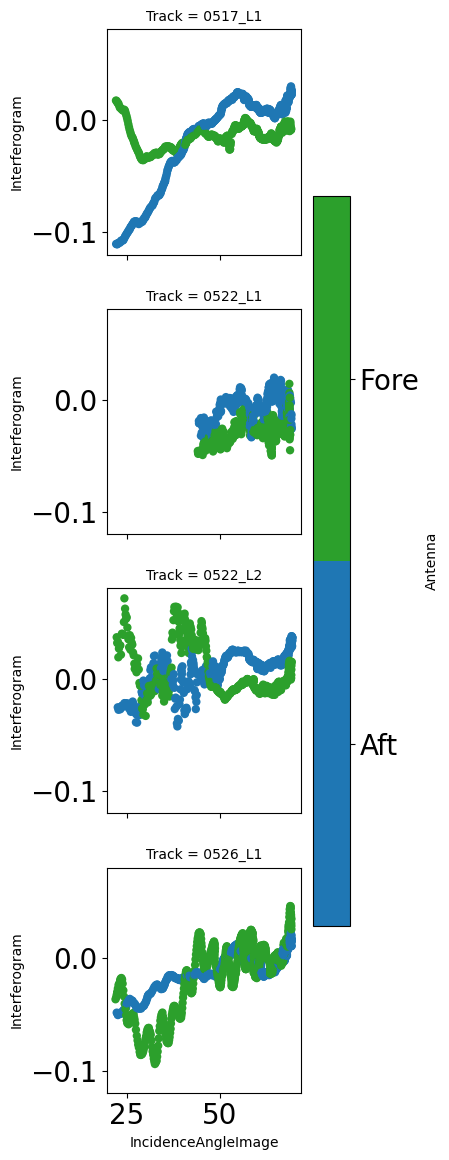

In [19]:
ds_phase.plot.scatter(x='IncidenceAngleImage', y='Interferogram', edgecolors='none',
                     hue='Antenna',
                      row='Track',
                     cmap=mpl.colors.ListedColormap(colors),
                     #cmap='Set1'
                     )

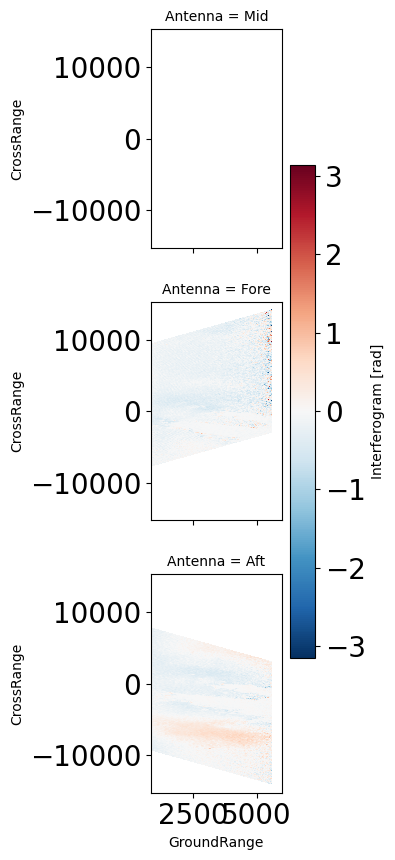

In [23]:
ds_L1b['0522_L1'].Interferogram.plot(row='Antenna',x='CrossRange',y=)

Text(0.5, 1.0, 'Interferometric phase over land, corrected')

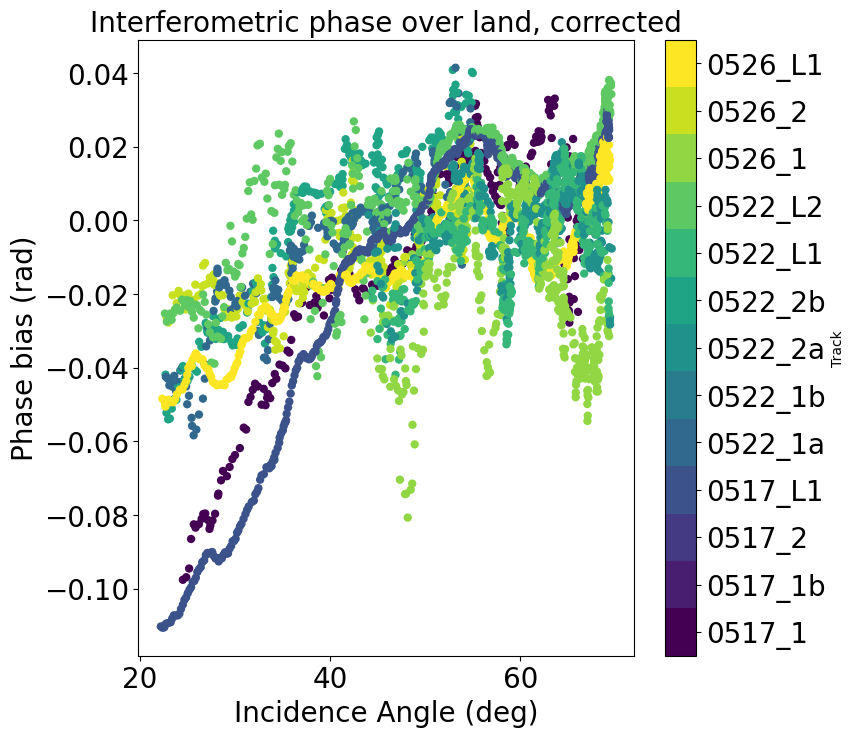

In [21]:
fig = plt.figure(figsize=(8,8))
ds_phase_corrected = ds_phase.copy(deep=True)
# ds_phase_corrected['Interferogram'].loc[dict({'Antenna': 'Fore'})] =\
#     ds_phase.Interferogram.sel(Antenna='Fore')\
#     - param_fore[0] * ds_phase.IncidenceAngleImage.sel(Antenna='Fore') - param_fore[1]
# ds_phase_corrected['Interferogram'].loc[dict({'Antenna': 'Aft'})] =\
#     ds_phase.Interferogram.sel(Antenna='Aft')\
#     - param_aft[0] * ds_phase.IncidenceAngleImage.sel(Antenna='Aft') - param_aft[1]
    
ds_phase_corrected.sel(Antenna='Aft').plot.scatter(x='IncidenceAngleImage', y='Interferogram',
                                                    edgecolors='none',
                               #cmap=mpl.colors.ListedColormap(colors)
                               )

plt.xlabel('Incidence Angle (deg)', fontsize=20)
plt.ylabel('Phase bias (rad)', fontsize=20)
plt.title('Interferometric phase over land, corrected', fontsize=20)

In [7]:
np.degrees(0.05)

2.8647889756541165

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\matplotlib\colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


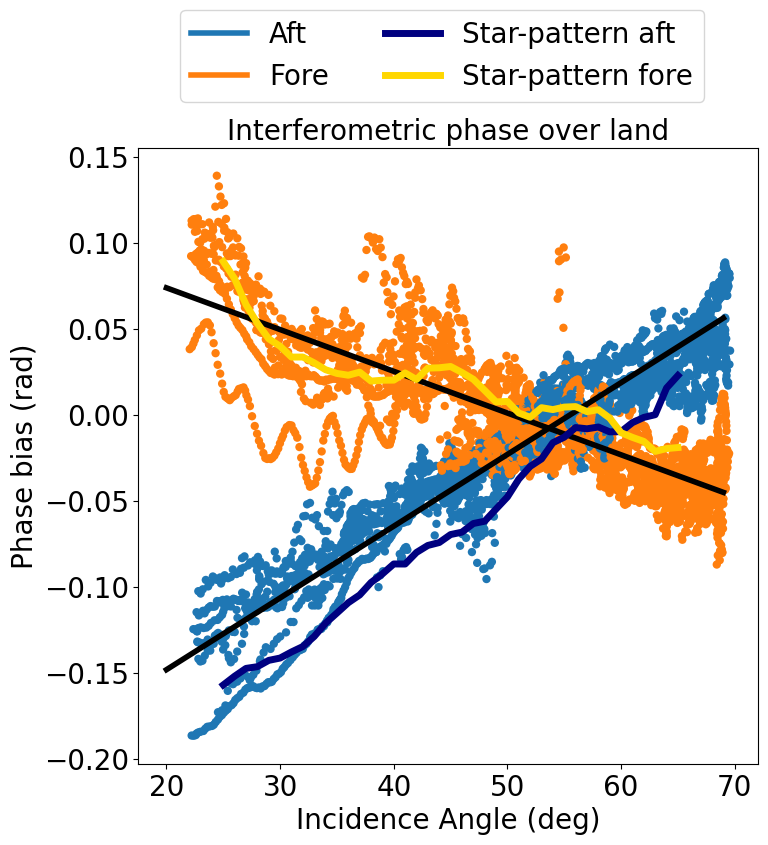

In [122]:
IA = xr.open_dataset('D:\\data\\SEASTAR\\SEASTARex\\Data\\calib\\star_pattern_interferogram_calib.nc')
#fig = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
colors=['C0','C1']
ds_phase.plot.scatter(x='IncidenceAngleImage', y='Interferogram',hue='Antenna', edgecolors='none',add_colorbar=False,
                     cmap=mpl.colors.ListedColormap(colors))
ax.get_legend().remove()
x = ds_phase.sel(Antenna='Fore').IncidenceAngleImage.mean(dim='Track')
y = ds_phase.sel(Antenna='Fore').Interferogram.mean(dim='Track')
param_fore, param_cov_fore = curve_fit(func_linear,
                             x[~np.isnan(y)],
                             y[~np.isnan(y)])
x = ds_phase.sel(Antenna='Aft').IncidenceAngleImage.mean(dim='Track')
y = ds_phase.sel(Antenna='Aft').Interferogram.mean(dim='Track')
param_aft, param_cov_aft = curve_fit(func_linear,
                             x[~np.isnan(y)],
                             y[~np.isnan(y)])
x = np.array([i for i in range(20,70)])

plt.plot(40,0,c='C0', linewidth=4,label='Aft' )
plt.plot(40,0,c='C1', linewidth=4,label='Fore' )
plt.plot(x, param_fore[0] * x + param_fore[1], linewidth=4, c='black')
plt.plot(x, param_aft[0] * x + param_aft[1], linewidth=4, c='black')
plt.plot(IA.inci,IA.sel(Antenna='Aft').Interferogram_popt, linewidth=5, color='navy', label='Star-pattern aft')
plt.plot(IA.inci,IA.sel(Antenna='Fore').Interferogram_popt, linewidth=5, color='gold', label='Star-pattern fore')


plt.xlabel('Incidence Angle (deg)', fontsize=20)
plt.ylabel('Phase bias (rad)', fontsize=20)
plt.title('Interferometric phase over land', fontsize=20)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.85,1.07))

# Fore fit


In [10]:
print('m =',np.round(param_fore[0],4))
print('c =',np.round(param_fore[1],4))

m = -0.0001
c = -0.0063


# Aft fit

In [11]:
print('m =', np.round(param_aft[0],4))
print('c =', np.round(param_aft[1],4))

m = 0.0012
c = -0.0704


In [127]:
ds_L1b['0517_1']

<xarray.Dataset>
Dimensions:              (Antenna: 3, CrossRange: 3148, GroundRange: 413)
Coordinates:
  * GroundRange          (GroundRange) float64 528.0 536.0 ... 3.824e+03
  * CrossRange           (CrossRange) float64 -1.254e+04 ... 1.264e+04
  * Antenna              (Antenna) <U4 'Mid' 'Fore' 'Aft'
    latitude             (CrossRange, GroundRange) float64 48.33 48.33 ... 48.55
    longitude            (CrossRange, GroundRange) float64 -5.103 ... -5.157
Data variables:
    Intensity            (Antenna, CrossRange, GroundRange) float64 nan ... nan
    Coherence            (Antenna, CrossRange, GroundRange) float64 nan ... nan
    Interferogram        (Antenna, CrossRange, GroundRange) float64 nan ... nan
    LatImage             (Antenna, CrossRange, GroundRange) float64 48.33 ......
    LonImage             (Antenna, CrossRange, GroundRange) float64 -5.103 .....
    IncidenceAngleImage  (Antenna, CrossRange, GroundRange) float64 nan ... nan
    SquintImage          (Antenna, CrossRange, GroundRange) float64 nan ... nan
    CentralFreq          (Antenna) float64 1.35e+10 1.35e+10 1.35e+10
    OrbitHeadingImage    (Antenna, CrossRange, GroundRange) float64 nan ... nan
    TrackTime            (Antenna) datetime64[ns] 2022-05-17T09:32:39 ... 202...
Attributes:
    Title:    Track : 20220517T093239

In [134]:
track = '0517_1'
mask_fore = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1b[track].Interferogram.sel(Antenna='Fore'),
                                                                quiet=True, erosion=True)
mask_aft = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1b[track].Interferogram.sel(Antenna='Aft'),
                                                                quiet=True, erosion=True)


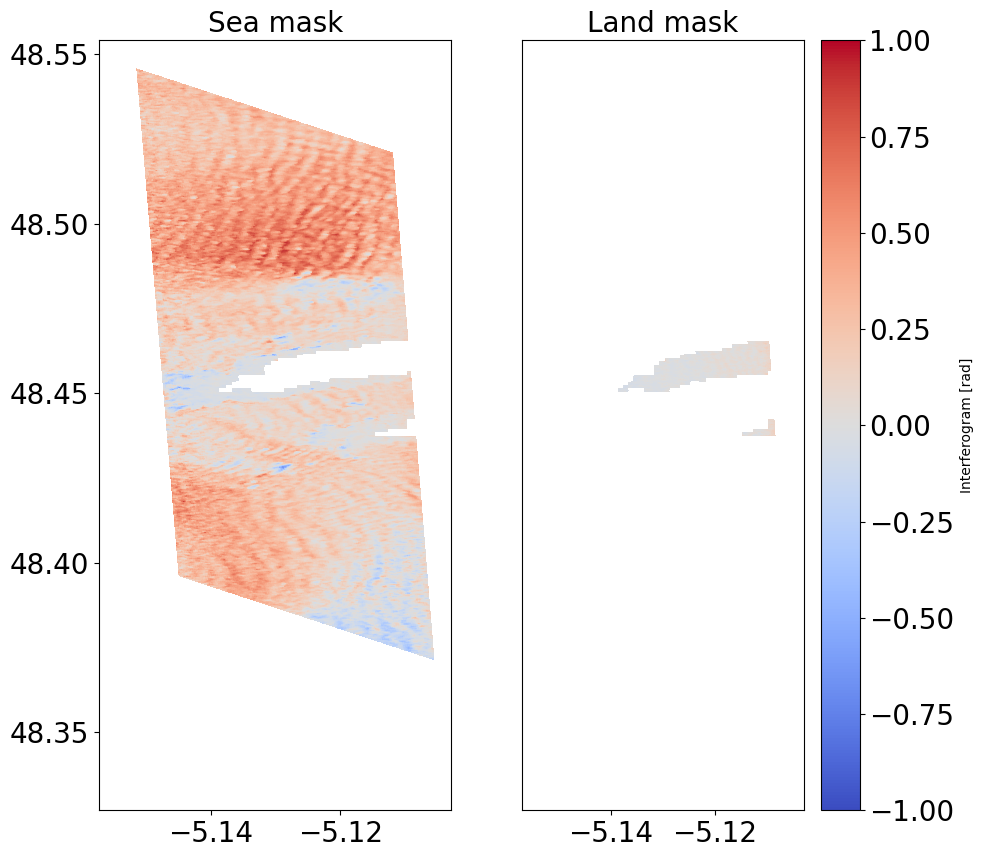

In [162]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
ds_L1b[track].sel(Antenna='Fore').Interferogram.where(mask_fore==0, np.nan).plot(y='latitude',x='longitude',
                                                                                vmin=-1, vmax=1,
                                                                                add_colorbar=False,
                                                                                cmap='coolwarm',
                                                                                )
plt.ylabel('')
plt.xlabel('')
plt.title('Sea mask')

ax = plt.subplot(1,2,2)
ds_L1b[track].sel(Antenna='Fore').Interferogram.where(mask_fore==1, np.nan).plot(y='latitude',x='longitude',
                                                                                vmin=-1, vmax=1,
                                                                                cmap='coolwarm')
plt.title('Land mask')
plt.xlabel('')
fig.axes[1].get_yaxis().set_visible(False)

In [125]:
def oscar_plot(im_dataset, im_var, figsize=(20, 10), plot_pixel_size=200, quivers=False, q_factor=30, u='',v='',
              coastline=False):
    sar_pixel_size = 8
    c_factor_image = int(plot_pixel_size / sar_pixel_size)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator(), frameon=True)
    im=im_dataset[im_var]\
    .coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
    .coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
    .plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    if quivers:
        im_dataset\
            .coarsen(GroundRange=q_factor,boundary='trim').mean()\
            .coarsen(CrossRange=q_factor,boundary='trim').mean()\
            .plot.quiver(
        x='longitude',
        y='latitude',
        u=u,
        v=v,
        scale=50,
        angles='xy',
        robust=True,
        transform=ccrs.PlateCarree()
)
    gl=ax.gridlines(draw_labels=True, color='gray')
    gl.top_labels=False
    gl.right_labels=False
    ax.set_extent([-5.2, -5.025, 48.37, 48.52], crs=ccrs.PlateCarree())
    if coastline:
        ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
        
    cbar = plt.colorbar(im)
    cbar.set_label('Retrieved Current Velocity (m/s)',fontsize=30)

    
    
    return